In [51]:
import numpy as np
import pandas as pd
import statsmodels as sm
import scipy.stats as stats
import os
import urllib
import csv
from bs4 import BeautifulSoup
import codecs

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
msft = pd.read_csv('data/MSFT_full.csv', index_col=0)

headlines = pd.read_csv("data/Headlines.csv", index_col=2)
headlines.index = pd.to_datetime(headlines.index)
headlines.head()

,Unnamed: 0,Title
Date,,
2017-09-12,1,How Apple's Face ID works - CNET
2017-09-12,2,How Microsoft is bringing the Internet of Thin...
2017-09-12,3,Developers: Watch Microsoft Edge Web Summit 20...
2017-09-12,4,'Transformers: The Last Knight' now available ...
2017-09-12,5,HP announces new premium commercial notebooks ...


In [3]:
headlines_byDate = {}
NUM_DAYS = len(headlines_byDate)
Date_List= headlines.index.unique()

for date in headlines.index.unique():
    str_date = ''
    for i in range(len(headlines[headlines.index==date])):
        str_date= str_date+' '+(headlines[headlines.index==date].Title[i]).upper()
    headlines_byDate[date] = str_date

In [4]:
Date_List[-1]

Timestamp('2014-03-27 00:00:00')

In [5]:
dict_fin = pd.read_excel('data/LoughranMcDonald_MasterDictionary_2014_lite.xlsx', index_col=0)
word_list = np.array(dict_fin.index)
features = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'Constraining', 'Superfluous', 'Interesting', 'Modal']

In [6]:
import time
start_time = time.time()

Estimate_date ={}
daily_mat = pd.DataFrame(columns=features, index=dict_fin.index)
daily_mat[:] = 0.0
summy_mat = pd.DataFrame(columns=features, index=Date_List)
summy_mat[:] = 0.0

for date in Date_List:
    daily_mat[:] = 0.0
    str_date = headlines_byDate[date]
    for word in word_list:
        ind = 0
        if word in str_date:
            for feature in features:
                if(dict_fin[dict_fin.index==word][feature].values>0):
                    daily_mat.iloc[daily_mat.index==word, daily_mat.columns==feature] = daily_mat.iloc[daily_mat.index==word, daily_mat.columns==feature] + 1
    summy_mat.iloc[summy_mat.index==date, :] = np.array(daily_mat.sum(axis=0))

print("--- %s seconds ---" % (time.time() - start_time))

--- 215.85921597480774 seconds ---


In [7]:
msft = pd.read_csv('Data/MSFT_full.csv', index_col= 0)
msft.head()
y_data = pd.DataFrame(index= msft.index[:-1], columns=['Returns'])

In [8]:
msft_returns = (msft['close'][:-1].values - msft['close'][1:].values)/msft['close'][1:].values
boundary = 0.3*np.std(msft_returns)
msft_returns_ind = msft_returns.copy()
for i in range(len(msft_returns)):
    if msft_returns[i]>boundary:
        msft_returns_ind[i] = 1
    elif msft_returns[i]<-boundary:
        msft_returns_ind[i] = -1
    else:
        msft_returns_ind[i] = 0
        

In [9]:
y_data['Returns'] = msft_returns_ind
y_data.head()
y_data.index = y_data.index.to_datetime()
Date_List_Trading = y_data.index 
x_data = pd.DataFrame(index= Date_List_Trading, columns=summy_mat.columns)

/Users/Xinhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
for date in Date_List_Trading:
    x_data[x_data.index==date] = summy_mat[summy_mat.index==date]

In [11]:
nan_index = (x_data['Positive'][x_data['Positive'].isnull().values]).index
x_data = x_data.drop(nan_index)
y_data = y_data.drop(nan_index)

In [13]:
from sklearn.svm import SVC

NUM_DATAPOINTS = len(x_data)
clf = SVC(decision_function_shape='ovo')
clf.fit(x_data[int(-0.9*NUM_DATAPOINTS):], y_data[int(-0.9*NUM_DATAPOINTS):]) 
y_pred = clf.predict(x_data[:int(0.1*NUM_DATAPOINTS)])

/Users/Xinhui/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


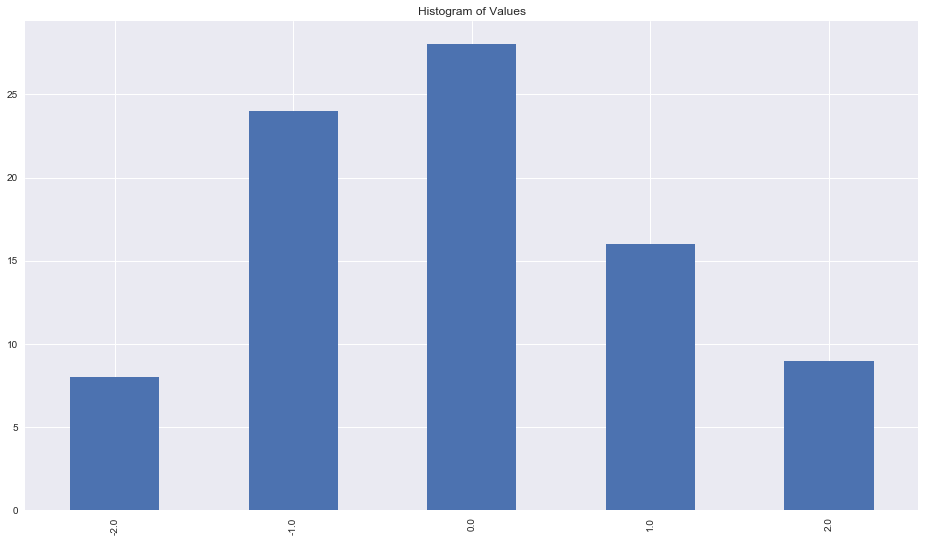

In [48]:
import seaborn
plt.figure(figsize = (16,9))
hist_= pd.DataFrame(y_data['Returns'][:int(0.1*NUM_DATAPOINTS)]-y_pred)
type(hist_)
bins = [-2, -1, 0, 1, 2]
#hist_ = hist_.groupby(pd.cut(hist_.values, bins=bins)).value_counts()
res=hist_['Returns'].value_counts()
res=res.sort_index()
res.plot(kind='bar', title='Histogram of Values',)

(array([  8.,  24.,  28.,  16.,   9.]),
 array([-2. , -1.2, -0.4,  0.4,  1.2,  2. ]),
 <a list of 5 Patch objects>)

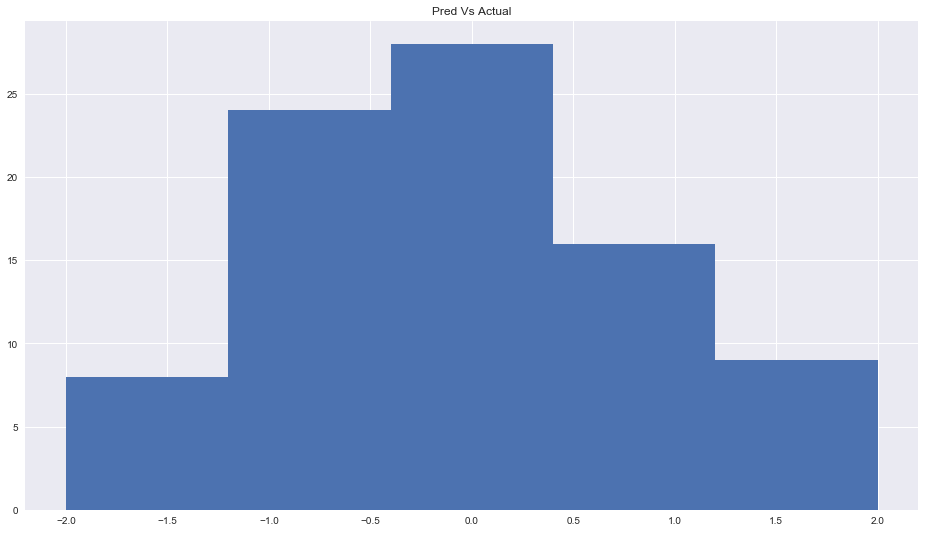

In [52]:
plt.figure(figsize = (16,9))
plt.title('Pred Vs Actual')
plt.hist(y_data['Returns'][:int(0.1*NUM_DATAPOINTS)]-y_pred, bins= 5, )

In [53]:
diff_soa = y_data['Returns'][:int(0.1*NUM_DATAPOINTS)]-y_pred
success_rate = len(diff_soa[diff_soa==0])/len(diff_soa)
print('Success Rate SOA Model: ', success_rate)

Success Rate SOA Model:  0.32941176470588235


# Benchmark Model

In [54]:
headlines_byDate = {}
NUM_DAYS = len(headlines_byDate)
Date_List= headlines.index.unique()

for date in headlines.index.unique():
    str_date = ''
    for i in range(len(headlines[headlines.index==date])):
        str_date= str_date+' '+(headlines[headlines.index==date].Title[i]).upper()
    headlines_byDate[date] = str_date

In [168]:
dict_fin = pd.read_excel('Data/LoughranMcDonald_MasterDictionary_2014_lite.xlsx', index_col=0)
word_list = np.array(dict_fin.index)
features_naive = ['Negative', 'Positive']

In [176]:
import time
start_time = time.time()

Estimate_date ={}
daily_mat = pd.DataFrame(columns=features, index=dict_fin.index)
daily_mat[:] = 0.0
summy_mat = pd.DataFrame(columns=features, index=Date_List)
summy_mat[:] = 0.0


for date in Date_List:
    estimate = 0
    daily_mat[:] = 0.0
    str_date = headlines_byDate[date]
    for word in word_list:
        ind = 0
        if word in str_date:
            if(dict_fin[dict_fin.index==word]['Positive'].values>0):
                estimate = estimate + 1
            if(dict_fin[dict_fin.index==word]['Negative'].values>0):
                estimate = estimate -1
            
    Estimate_date[date] = estimate
    summy_mat.iloc[summy_mat.index==date, :] = np.array(daily_mat.sum(axis=0))

pre_data=[]
for date in Date_List:
    pre_data.append(Estimate_date[date])
threshold_pred = 0.3*np.std(pre_data)

print("--- %s seconds ---" % (time.time() - start_time))

--- 50.05333089828491 seconds ---


## Benchmark Prediction

In [178]:
y_pred = []
for date in y_data['Returns'].index:
    if(Estimate_date[date]>threshold_pred):
        y_pred.append(1)
    elif(Estimate_date[date]<-threshold_pred):
        y_pred.append(-1)
    else:
        y_pred.append(0)

In [160]:
length = 10
threshold = 0.013
y_data.index = pd.to_datetime(y_data.index)

label = np.zeros(len(msft_returns)-length+1)
for i in range(len(label)):
    if max(np.cumprod(msft_returns[i:i+length])) > 1+threshold:
        label[i] = 1
    elif min(np.cumprod(msft_returns[i:i+length])) < 1-threshold:
        label[i] = -1


In [161]:
result_bm = []
delete_date = []
for date in y_data.index:
    if(len(Date_List[Date_List==date])>0):
        result_bm.append(Estimate_date[Date_List[Date_List==date][0]])
    else:
        delete_date.append(date)
    
result_bm = np.array(result_bm)
boundary = 0.3*np.std(result_bm)
result_bm_ind = result_bm.copy()
for i in range(len(result_bm)):
    if result_bm[i]>boundary:
        result_bm_ind[i] = 1
    elif result_naive[i]<-boundary:
        result_bm_ind[i] = -1
    else:
        result_bm_ind[i] = 0


In [162]:
y_data = y_data.drop(delete_date)


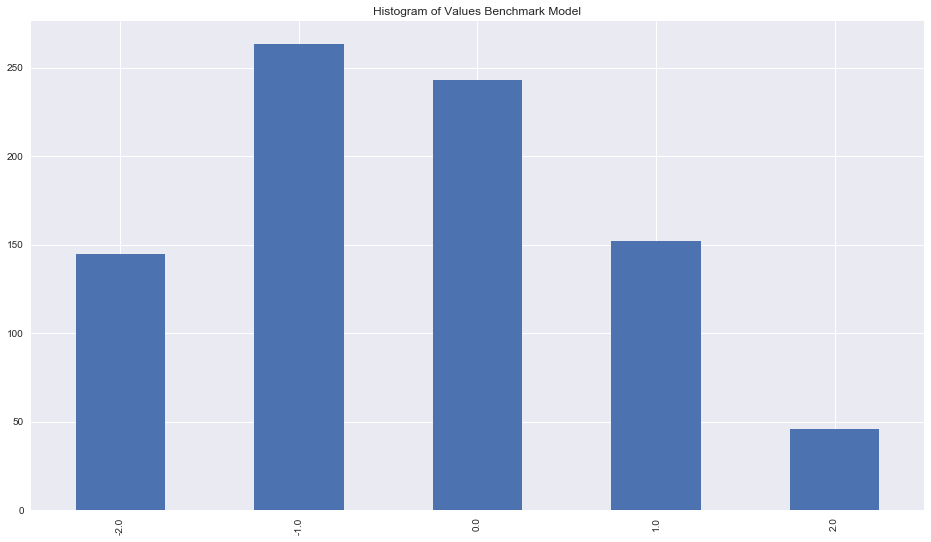

In [179]:
import seaborn
plt.figure(figsize = (16,9))
hist_= pd.DataFrame(y_pred-y_data['Returns'].values)
type(hist_)
bins = [-2, -1, 0, 1, 2]
#hist_ = hist_.groupby(pd.cut(hist_.values, bins=bins)).value_counts()
res=hist_[0].value_counts()
res=res.sort_index()
res.plot(kind='bar', title='Histogram of Values Benchmark Model',)

In [164]:
diff_naive = result_bm_ind-y_data['Returns'].values
success_rate_naive = len(diff_naive[diff_naive==0])/len(diff_naive)

In [165]:
print('Success Rate Naive Model: ', success_rate_naive)

Success Rate Naive Model:  0.2862190812720848
